# Семинар 4. Uplift и LaL



## 1. Lenta Uplift Modeling Dataset

[На основе туториалов билтиотеки sk-uplift](https://github.com/maks-sh/scikit-uplift/blob/master/notebooks/uplift_model_selection_tutorial.ipynb)

Лента это сеть продуктовых, в самом датасете есть данные о кампаниях, которые запускались

Датасет изначально выложили для соревнования [BIGTARGET Hackathon by LENTA and Microsoft](https://bigtarget.online/) и он доступен из модуля `sklift.datasets` используя `fetch_lenta`.

Документация по датасету <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.

In [ ]:
import sys

!{sys.executable} -m pip install scikit-uplift catboost -q

In [ ]:
!{sys.executable} -m pip install scikit-learn==1.4.2 -q

In [ ]:
from sklift.datasets import fetch_lenta
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

%matplotlib inline

In [ ]:
dataset = fetch_lenta()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

dataset.keys()

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

Dataset is a dictionary-like object with the following attributes:
* ``data`` (DataFrame object): Dataset without target and treatment.
* ``target`` (Series object): Column target by values.
* ``treatment`` (Series object): Column treatment by values.
* ``DESCR`` (str): Description of the Lenta dataset.
* ``feature_names`` (list): Names of the features.
* ``target_name`` (str): Name of the target.
* ``treatment_name`` (str): Name of the treatment.
                
**Major columns:**
- treatment `group` (str): test/control group flag
- target `response_att` (binary): target
- data `gender` (str): customer gender
- data `age` (float): customer age
- data `main_format` (int): store type (1 - grociery store, 0 - superstore)

Detailed feature description could be found [here](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta).

### Target share for `treatment / control`

<Axes: xlabel='response_att', ylabel='count'>

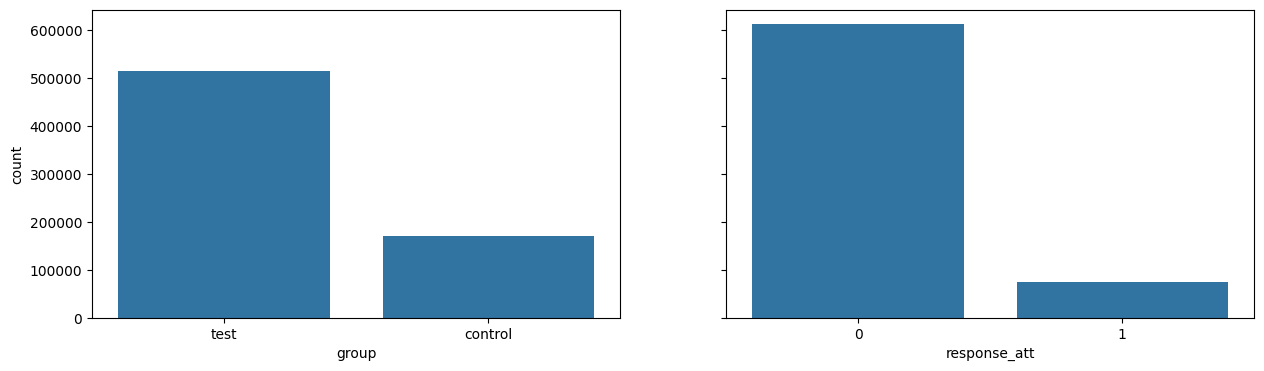

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))

treatment = dataset["treatment"]
target = dataset["target"]

sns.countplot(x=treatment, ax=ax[0])
sns.countplot(x=target, ax=ax[1])

The current sample is unbalanced in terms of both treatment and target.

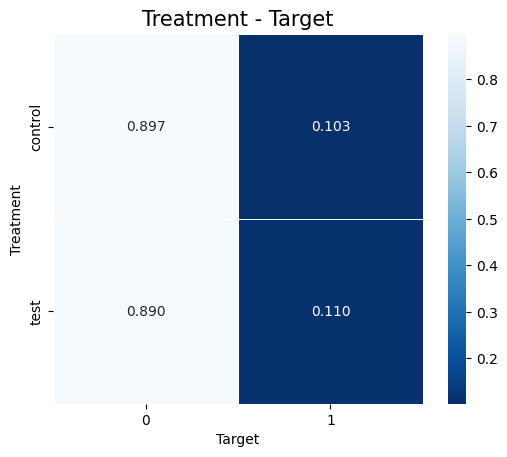

In [ ]:
def crosstab_plot(treatment, target):
    ct = pd.crosstab(treatment, target, normalize='index')

    sns.heatmap(ct, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Treatment')
    plt.xlabel('Target')
    plt.title("Treatment - Target", size = 15)

crosstab_plot(dataset.treatment, dataset.target)

### Distributions of some features by treatment

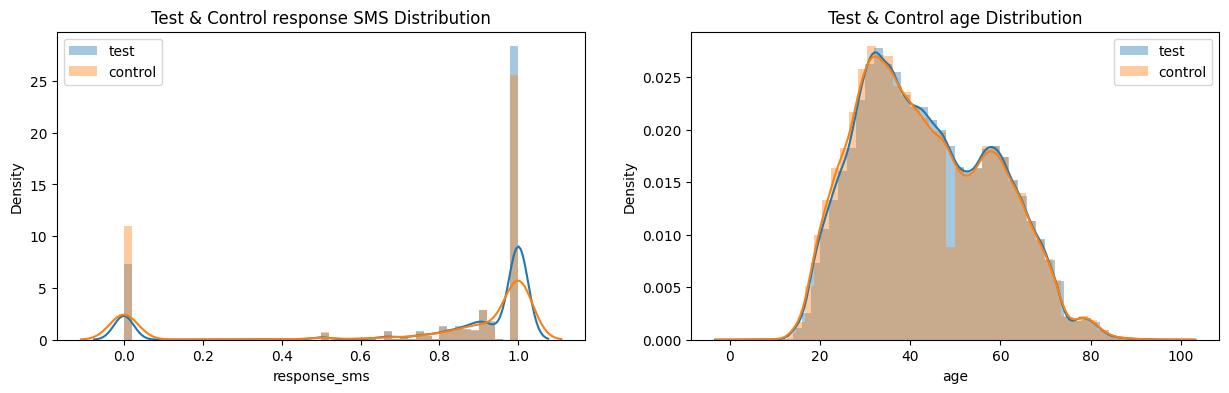

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

test_index = dataset.treatment[dataset.treatment == 'test'].index
control_index = dataset.treatment[dataset.treatment == 'control'].index

sns.distplot(dataset.data.loc[test_index, 'response_sms'], label='test', ax=ax[0])
sns.distplot(dataset.data.loc[control_index, 'response_sms'], label='control', ax=ax[0])
ax[0].title.set_text('Test & Control response SMS Distribution')
ax[0].legend()

sns.distplot(dataset.data.loc[test_index, 'age'], label='test', ax=ax[1])
sns.distplot(dataset.data.loc[control_index, 'age'], label='control', ax=ax[1])
ax[1].title.set_text('Test & Control age Distribution')
ax[1].legend()

Clients from the test treatment group tend to respond to sms with a slightly greater probability than clients from the control group. The behavior in the test and control groups does not differ depending on the clients age.

### Data analysys

In [ ]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 193 entries, age to stdev_discount_depth_1m
dtypes: float64(191), int64(1), object(1)
memory usage: 1011.6+ MB


In [ ]:
pd.concat([dataset.data.head() , dataset.data.tail()])

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_g27,sale_sum_12m_

* There are 193 columns in the dataset
* The dataset contains:
    - basic information about clients (age, number of children)
    - information about some groups of goods
    - statistical information (variation of discounts, prices)


### Missing values

In [ ]:
# check NaN values ratio
pd.DataFrame({"Total" : dataset.data.isna().sum().sort_values(ascending = False),
              "Percentage" : round(dataset.data.isna().sum().sort_values(ascending = False) / len(dataset.data), 3)}).head(20)


,Total,Percentage
k_var_sku_price_15d_g49,496259,0.722
k_var_disc_share_15d_g49,496159,0.722
k_var_count_per_cheque_15d_g34,468551,0.682
k_var_sku_price_15d_g34,468551,0.682
k_var_disc_share_15d_g34,468467,0.682
k_var_count_per_cheque_15d_g24,442121,0.644
k_var_disc_share_15d_g24,442054,0.643
k_var_sku_price_1m_g49,414473,0.603
k_var_count_per_cheque_1m_g49,414473,0.603
k_var_disc_share_1m_g49,414369,0.603


In [ ]:
print('Total missed data percentage:',
      round(100*dataset.data.isna().sum().sum()/(dataset.data.shape[0]*dataset.data.shape[1]), 2), '%')


Total missed data percentage: 19.34 %


### Data transformation

Transform categorical columns `gender` and `treatment` into binary.

In [ ]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}
dataset.treatment = dataset.treatment.map(treat_dict)

# make gender binary
gender_dict = {
    'M': 1,
    'Ж': 0
}
dataset.data.gender = dataset.data.gender.map(gender_dict)


### Feature correlation

In [ ]:
%%time
corr_m = dataset.data.corr()

CPU times: user 1min 28s, sys: 340 ms, total: 1min 29s
Wall time: 1min 30s


<Figure size 1900x1500 with 0 Axes>

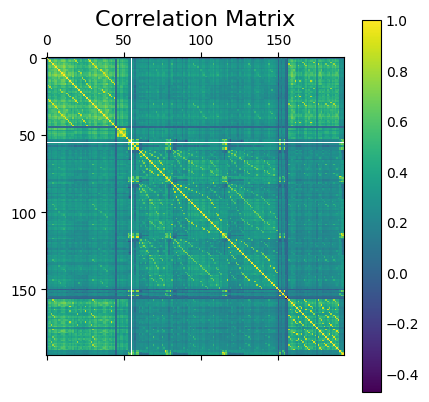

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_m)#, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Correlation Matrix', fontsize=16);

### Train/test split

- stratify by two columns: treatment and target.

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one.

In [ ]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


### Pipeline with CatBoostClassifier

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
estimator = CatBoostClassifier(verbose=100,
                               random_state=42,
                               thread_count=1)
ct_model = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([
    ('imputer', imp_mode),
    ('model', ct_model)
])

Usual fit pipeline but with aditional treatment parameter
`model__treatment = trmnt_train`.
    

In [ ]:
my_pipeline = my_pipeline.fit(
    X=X_train,
    y=y_train,
    model__treatment=trmnt_train
)

Learning rate set to 0.143939
0:	learn: 0.6692264	total: 579ms	remaining: 9m 38s
100:	learn: 0.5950484	total: 52.4s	remaining: 7m 46s
200:	learn: 0.5908476	total: 1m 41s	remaining: 6m 43s
300:	learn: 0.5871219	total: 2m 29s	remaining: 5m 47s
400:	learn: 0.5834411	total: 3m 22s	remaining: 5m 2s
500:	learn: 0.5801309	total: 4m 11s	remaining: 4m 10s
600:	learn: 0.5769242	total: 4m 59s	remaining: 3m 18s
700:	learn: 0.5736238	total: 5m 48s	remaining: 2m 28s
800:	learn: 0.5705597	total: 6m 37s	remaining: 1m 38s
900:	learn: 0.5674382	total: 7m 28s	remaining: 49.2s
999:	learn: 0.5645905	total: 8m 17s	remaining: 0us


Predict uplift and calculate basic uplift metric **uplift@30%** at first 30%. Read more about the metric [in docs](https://www.uplift-modeling.com/en/latest/api/metrics/uplift_at_k.html).

In [ ]:
uplift_predictions = my_pipeline.predict(X_val)

#uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall')
uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='by_group')
print(f'uplift@30%: {uplift_30:.4f}')

uplift@30%: 0.0314


In [ ]:
models_results = {'approach' : [], 'uplift@30%' : []}
models_results['approach'].append('pipe')
models_results['uplift@30%'].append(uplift_30)

##  1. Подходы с одной моделью



### 1.1 Одна модель с признаком коммуникации (S-learner)
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift. 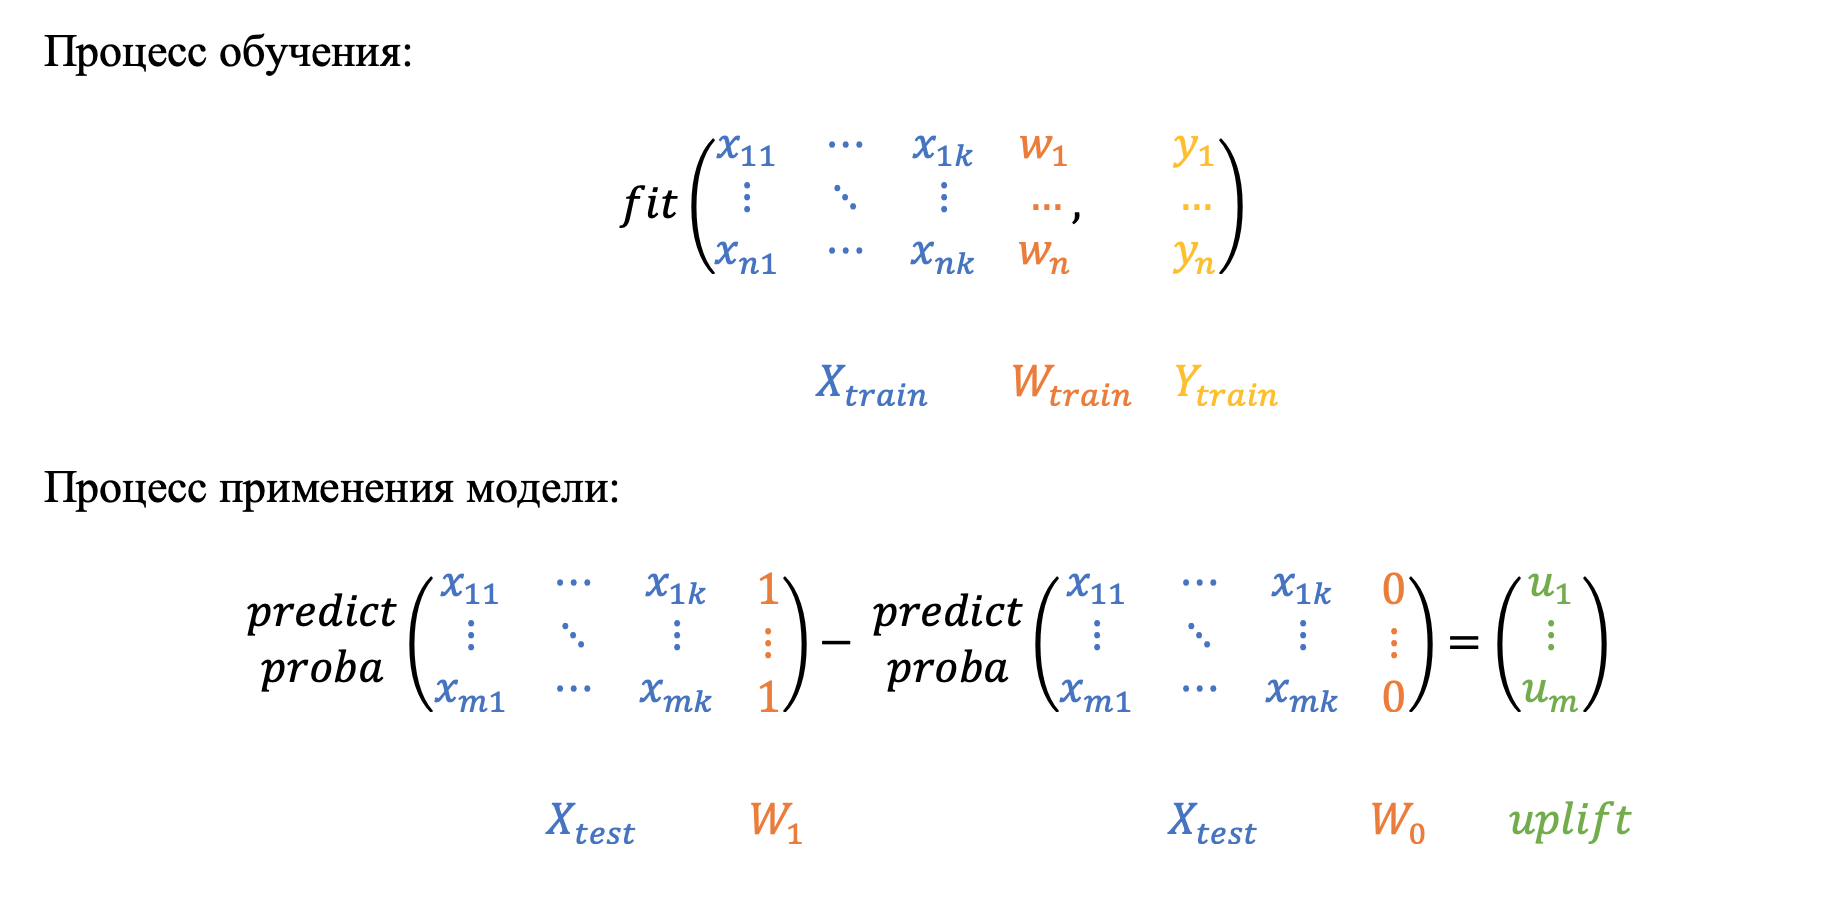

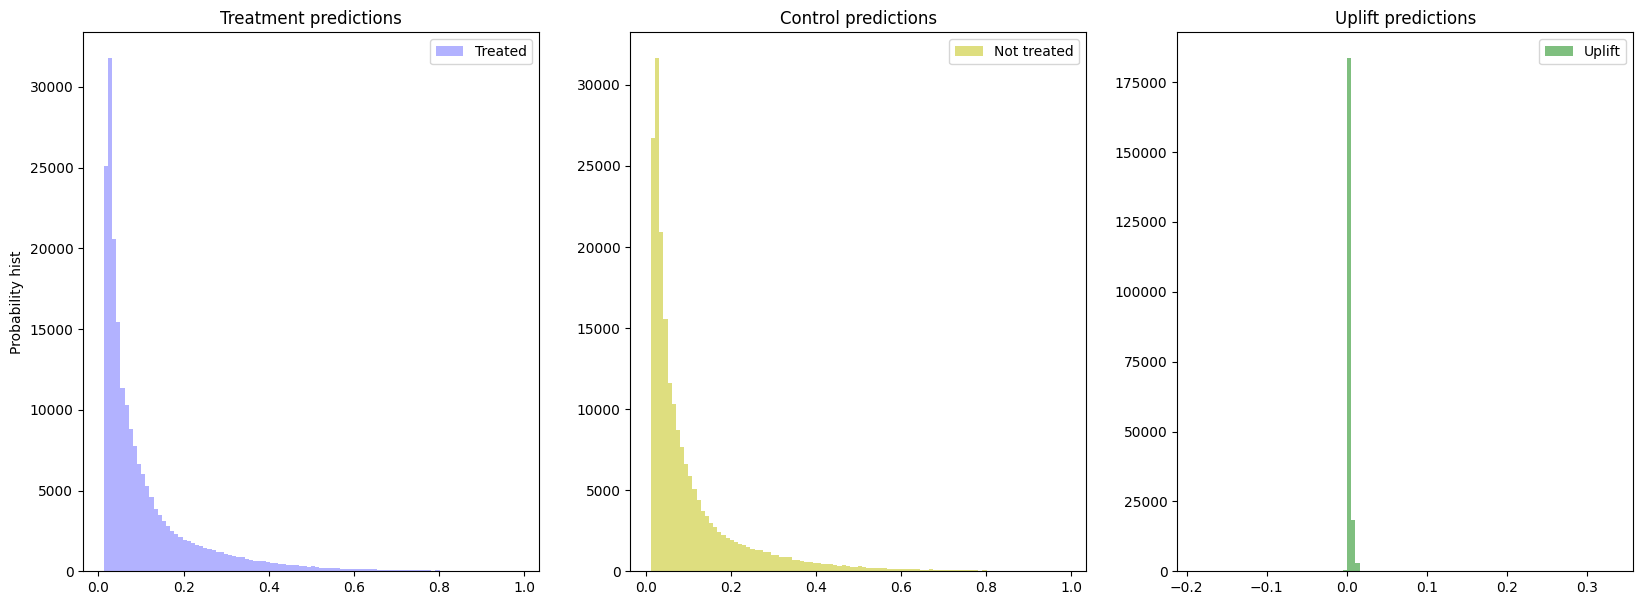

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm_pipeline = Pipeline([
    ('imputer', imp_mode),
    ('model', sm)
])

sm_pipeline = sm_pipeline.fit(
    X=X_train,
    y=y_train,
    model__treatment=trmnt_train
)


#sm = sm.fit(X_train, y_train, trmnt_train)
uplift_sm = sm_pipeline.predict(X_val)
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_pipeline['model'].trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_pipeline['model'].ctrl_preds_

# # Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


In [ ]:
models_results

{'approach': ['pipe', 'SoloModel'],
 'uplift@30%': [0.03139659550634985, 0.011857502164057954]}

### 1.2 Трансформация классов

Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$
где

* $Z_i$ - новая целевая переменная $i$-ого клиента;
* $Y_i$ - целевая перемнная $i$-ого клиента;
* $W_i$ - флаг коммуникации $i$-ого клиента;  


Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Распишем подробнее, чему равна вероятность новой целевой переменной:

$$
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.

$$
uplift = 2 \cdot P(Z=1) - 1
$$

Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было.

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, trmnt_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [ ]:
models_results

{'approach': ['pipe', 'SoloModel', 'ClassTransformation'],
 'uplift@30%': [0.03139659550634985,
  0.011857502164057954,
  0.03161840043430228]}

## 1.2. Подходы с двумя моделями
Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в документации scikit-learn.

## HW Добавить калибровку

### 1.2.1 Две независимые модели (T-learners)
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

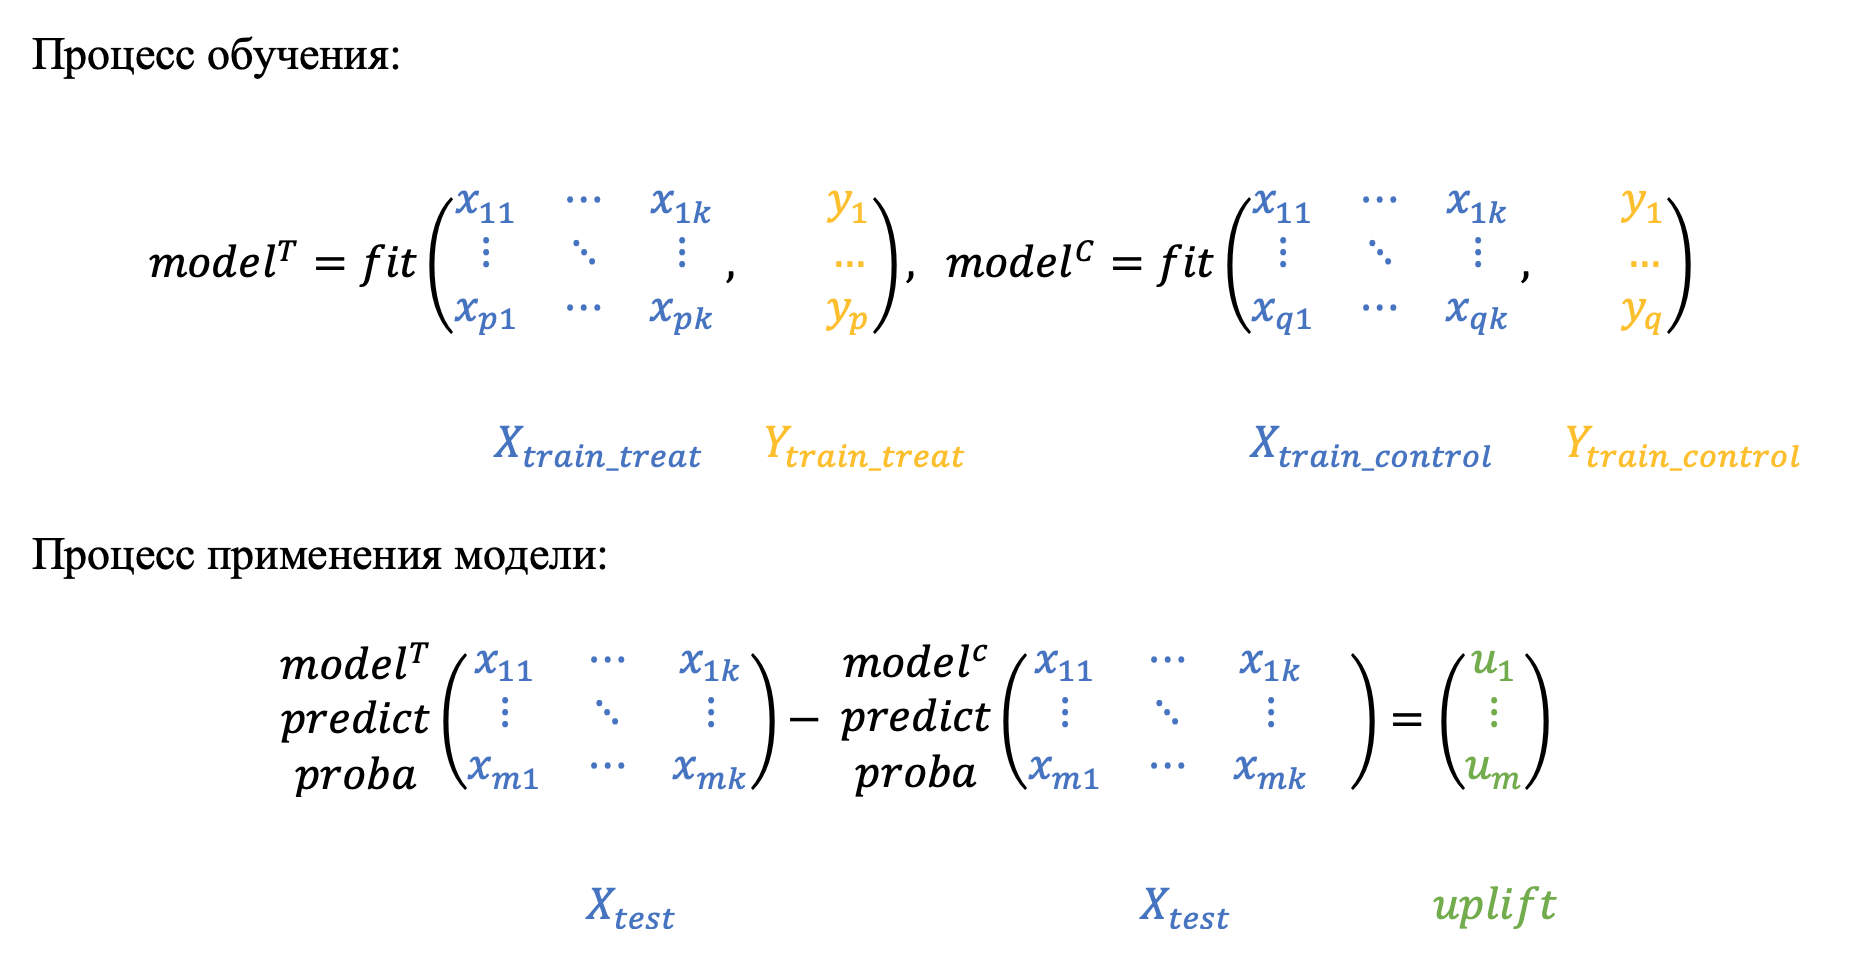


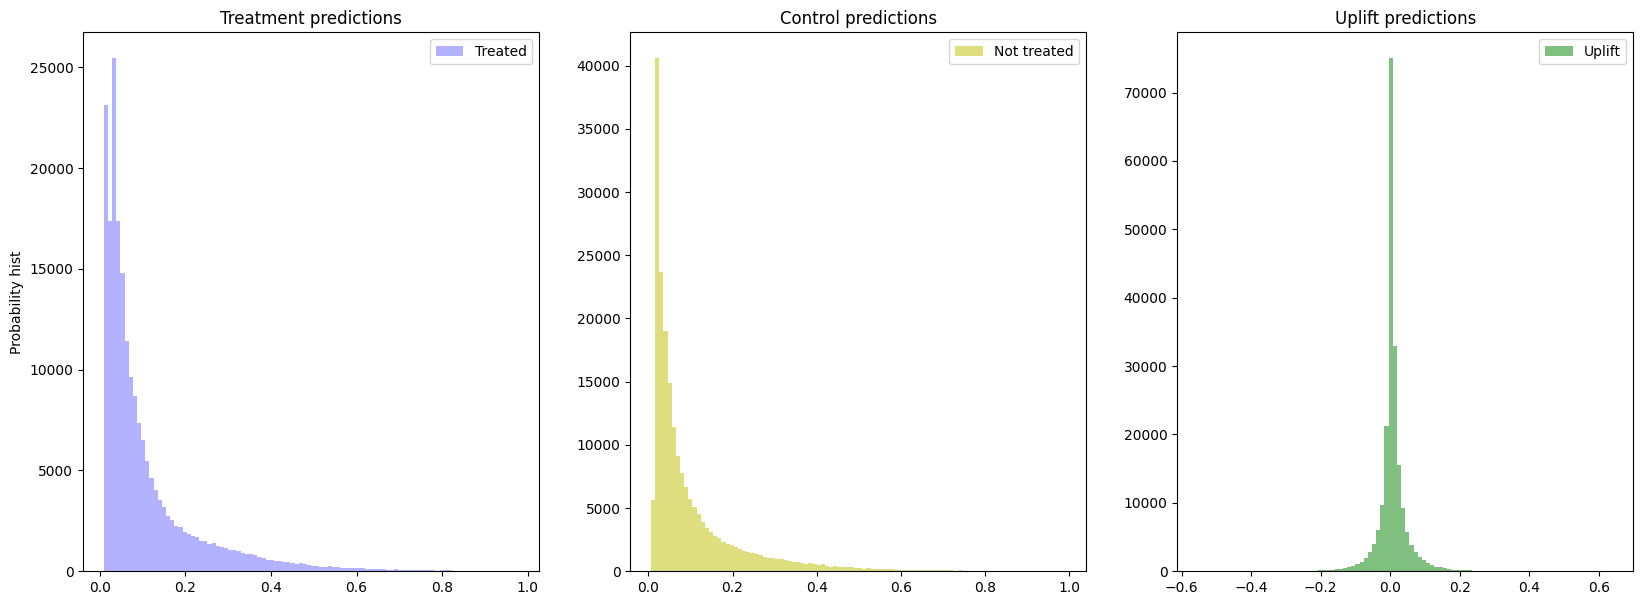

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, trmnt_train
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
models_results

{'approach': ['pipe', 'SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@30%': [0.03139659550634985,
  0.011857502164057954,
  0.03161840043430228,
  0.0097187352532431]}

### 2.2 Две зависимые модели (Dependent Data Representation)

Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным:
$$
P^C = P(Y=1| X, W = 0),
$$
затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

Чтобы получить uplift для каждого наблюдения, вычислим разницу:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

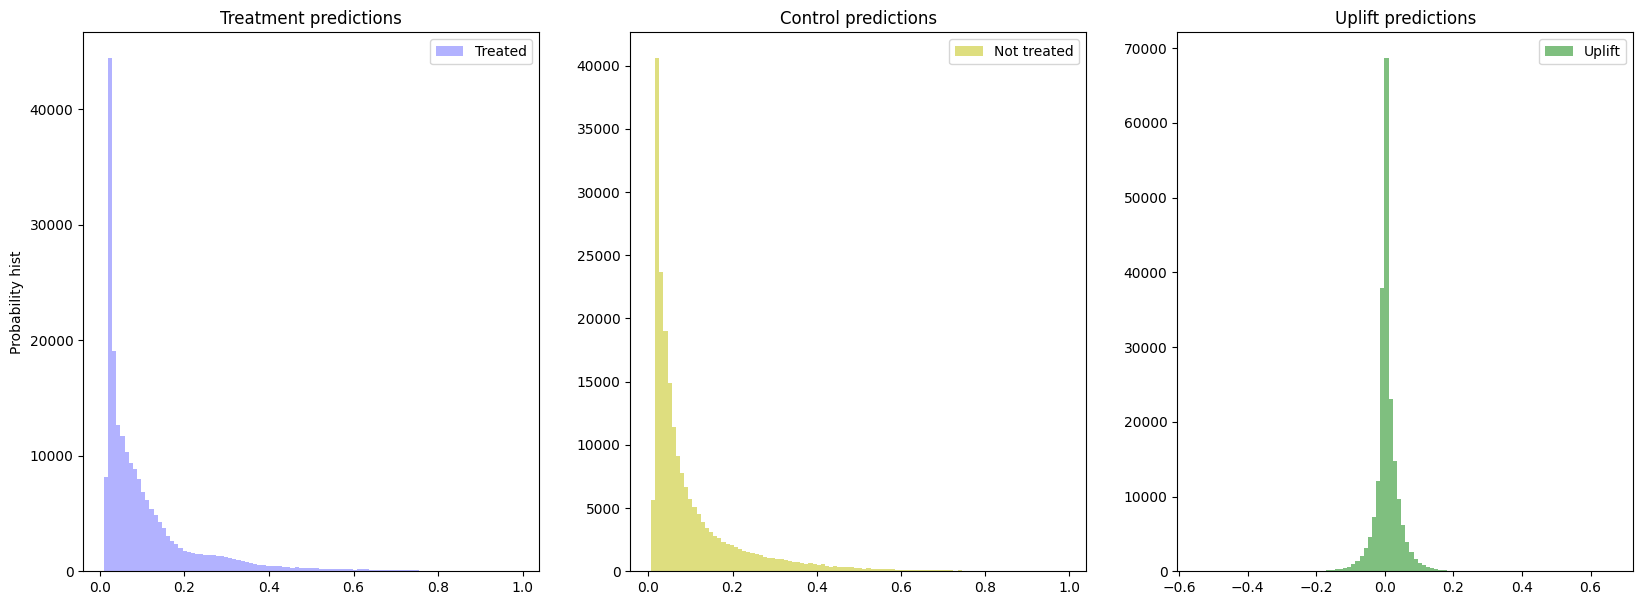

In [ ]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, trmnt_train
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

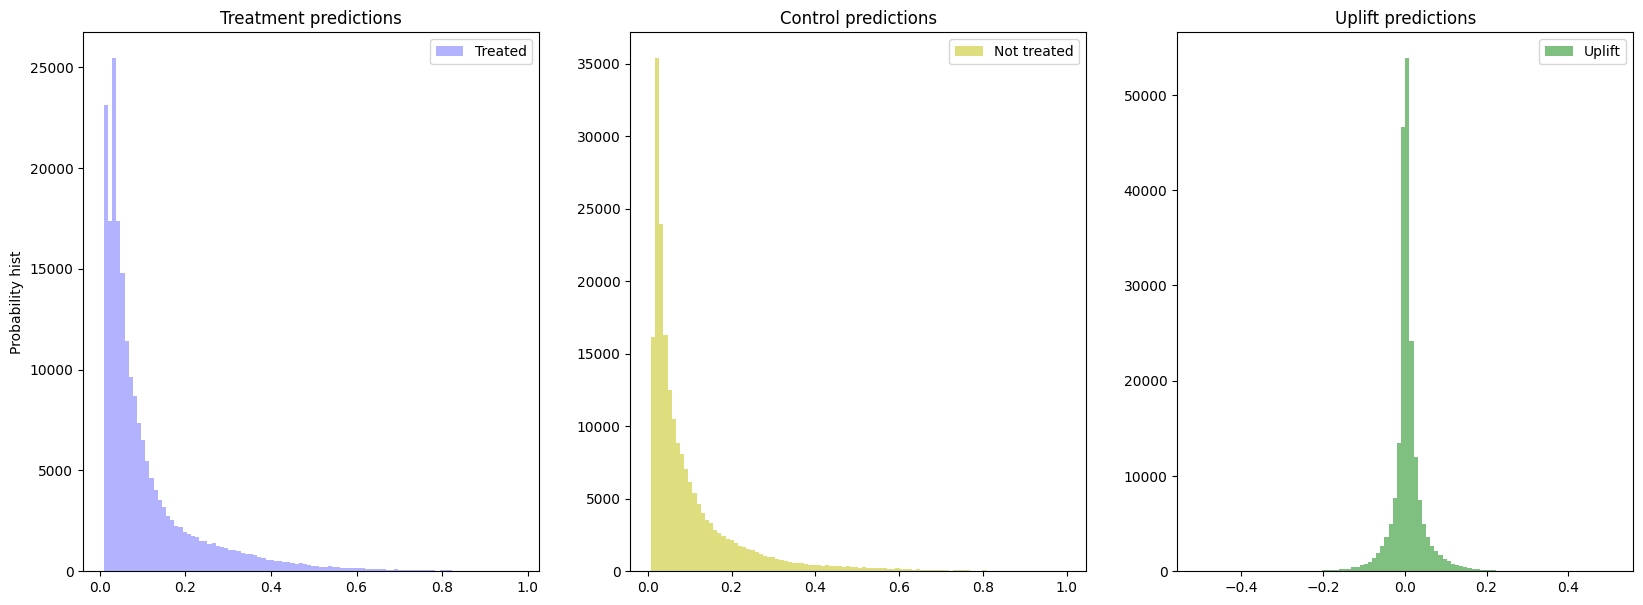

In [ ]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, trmnt_train
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Заключение
Рассмотрим, какой метод лучше всего показал себя в этой задаче:

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,ClassTransformation,0.031618
0,pipe,0.031397
5,TwoModels_ddr_treatment,0.014210
4,TwoModels_ddr_control,0.013833
1,SoloModel,0.011858
3,TwoModels,0.009719


### Qini для победившей модели

In [ ]:
from sklift.viz import plot_qini_curve

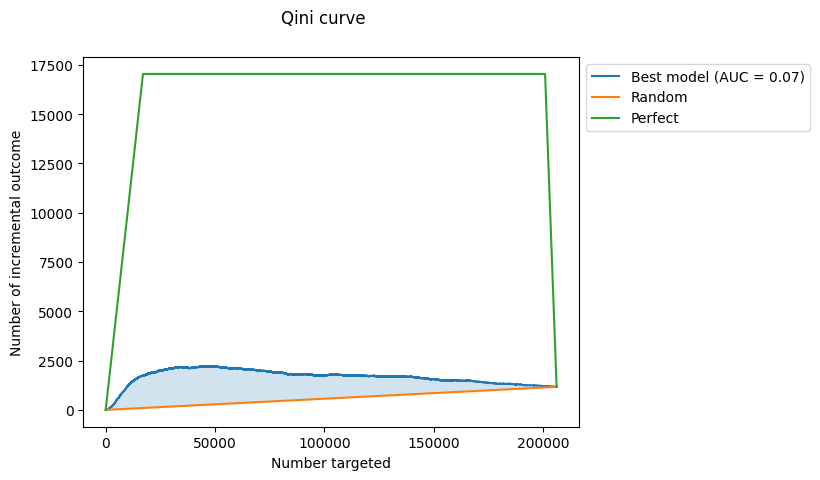

In [ ]:
uplift_ct = ct.predict(X_val)
bets_disp = plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");

Еще больше методов [здесь](https://habr.com/ru/companies/glowbyte/articles/686398/):

*   X-learner
*   Domain Adaptation Learner
*   R-learner
*   DR-learner
*   Doubly Robust Instrumental Variable (DRIV) learner

# 2. Multi-treatment Uplift

Рассмотрим кейс когда воздействия на клиента могут быть разные

! для использования pyboost переключитесь на среду с GPU / TPU


[Uplift Modelling via Gradient Boosting | Proceedings of the 30th ACM SIGKDD](https://dl.acm.org/doi/10.1145/3637528.3672019)


В августе 2024 коллеги из Sber AI Lab опубликовали на KDD'24 (core-A*) конференции новый подход к задаче uplift: two-staged GBDT для предсказания uplift (в т.ч. multi-treatment), который позволяет более точно оценивать какое именно действие из конкретного списка принесет наибольший эффект для конкретного клиента.
На библиотеке PyBoost их же разработки



далее приводится туториал одного из авторов статьи -- Антона Вахрушева

In [ ]:
!pip -q install -U py-boost scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import os
import cupy as cp
from py_boost.gpu.losses import BCELoss, BCEMetric, MSELoss, Loss, Metric, RMSEMetric
from py_boost import GradientBoosting, Callback
from py_boost.multioutput.sketching import GradSketch

from sklearn.model_selection import train_test_split
from sklift.metrics import qini_auc_score

In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/uplift_Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv

--2025-01-23 18:56:39--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/uplift_Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3900976 (3.7M) [text/plain]
Saving to: ‘uplift_Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv’

uplift_Kevin_Hillst 100%[===================>]   3.72M  --.-KB/s    in 0.03s   

2025-01-23 18:56:39 (114 MB/s) - ‘uplift_Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv’ saved [3900976/3900976]



In [ ]:
data = pd.read_csv('uplift_Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv') \
    .drop(['conversion', 'spend'], axis=1)
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0
...,...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0


## 2.1. Препроцессинг

In [ ]:
data['history_segment'] = data['history_segment'].map(
    lambda x: int(x[4:].split('-')[0].replace(',', '').replace('+', ''))
)
for col in ['zip_code', 'channel']:
    data[col] = pd.factorize(data[col])[0]

data['segment'] = data['segment'].map({
    'No E-Mail': 0,
    'Womens E-Mail': 1,
    'Mens E-Mail': 2
})

In [ ]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,100,142.44,1,0,0,0,0,1,0
1,6,200,329.08,1,1,1,1,1,0,0
2,7,100,180.65,0,1,0,1,1,1,0
3,9,500,675.83,1,0,1,1,1,2,0
4,2,0,45.34,1,0,2,0,1,1,0


## 2.2. Задача

Нам надо оценить эффект на целевую visit от нашего действия - отправки email. Мы можем отправить мужской или женский email, или не отправить вообще. За действие в выборке отвечает колонка segment. Группу 0 мы считаем контрольной, 1 и 2 это наши тритменты, эффект от которых мы хотим оценить. Остальное просто фичи.

In [ ]:
X = data.drop(['segment', 'visit'], axis=1).astype(np.float32).values

y = data['visit'].astype(np.int32).values
t = data['segment'].values

Первый шаг - сделать специальную трансформацию таргета.     
Переведем наш таргет в размер

```
N_samples x N_treatments,
где y_uplift[i, j] = y[i] if t[i] == j else np.nan.
```

Итого, в строке только 1 ячейка не NAN

In [ ]:
n_trt = t.max() + 1
y_uplift = np.where(
    t[:, np.newaxis] == np.arange(n_trt)[np.newaxis, :],
    y[:, np.newaxis], np.nan
)
y_uplift

array([[nan,  0., nan],
       [ 0., nan, nan],
       [nan,  0., nan],
       ...,
       [nan, nan,  0.],
       [nan,  0., nan],
       [nan, nan,  0.]])

для простоты без кросс-валидации и отложенного теста:

In [ ]:
X_tr, X_val, y_tr, y_val, t_tr, t_val, y_uplift_tr, y_uplift_val = train_test_split(
    X, y, t, y_uplift, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
X_tr, X_val

(array([[  7.  , 350.  , 434.35, ...,   2.  ,   1.  ,   1.  ],
        [  1.  , 350.  , 376.59, ...,   0.  ,   0.  ,   2.  ],
        [  3.  , 100.  , 140.34, ...,   2.  ,   1.  ,   0.  ],
        ...,
        [  8.  , 350.  , 492.53, ...,   1.  ,   1.  ,   0.  ],
        [  5.  ,   0.  ,  72.28, ...,   2.  ,   1.  ,   1.  ],
        [  3.  , 750.  , 787.51, ...,   2.  ,   1.  ,   2.  ]],
       dtype=float32),
 array([[  9.  ,   0.  ,  64.85, ...,   0.  ,   1.  ,   1.  ],
        [  1.  , 100.  , 144.12, ...,   2.  ,   0.  ,   1.  ],
        [  1.  , 500.  , 734.25, ...,   0.  ,   1.  ,   0.  ],
        ...,
        [  4.  ,   0.  ,  33.63, ...,   2.  ,   1.  ,   1.  ],
        [  6.  ,   0.  ,  82.  , ...,   2.  ,   1.  ,   0.  ],
        [  6.  ,   0.  ,  88.46, ...,   2.  ,   1.  ,   1.  ]],
       dtype=float32))

## 2.3. Модель

Поднастроим pyboost

In [ ]:
class LossNaNHandler(Loss):
    """
    Loss wrapper to mask NaNs
    """
    def __init__(self, base_loss):

        self.base_loss = base_loss

    def base_score(self, y_true):
        # Replace .mean with nanmean function to calc base score
        means = cp.nanmean(y_true, axis=0)
        # TODO: it is just a simple handler - for regression and classification should work
        means = means[np.newaxis, :]
        means = self.base_loss.base_score(means)
        return means

    def postprocess_output(self, y_pred):
        return self.base_loss.postprocess_output(y_pred)

    def get_grad_hess(self, y_true, y_pred):
        # first, get nan mask for y_true
        mask = cp.isnan(y_true)
        # then, compute loss with any values at nan places just to prevent the exception
        grad, hess = self.base_loss.get_grad_hess(cp.where(mask, 0, y_true), y_pred)
        # invert mask
        mask = (~mask).astype(cp.float32)
        # multiply grad and hess on inverted mask
        # now grad and hess eq. 0 on NaN points
        # that actually means that prediction on that place should not be updated
        grad = grad * mask
        hess = hess * mask

        return grad, hess


class UpliftLoss(LossNaNHandler):
    """
    Uplift loss wrapper extra post process fn over LossNaNHandler
    """
    def __init__(self, base_loss, uplift=False):
        super().__init__(base_loss)
        self.uplift = uplift

    def postprocess_output(self, y_pred):

        y_pred = super().postprocess_output(y_pred)
        if self.uplift:
            y_pred = y_pred[:, 1:] - y_pred[:, :1]

        return y_pred

class MetricNaNHandler(Metric):
    """
    Metric NaN handler. There are multiple ways to implement this
    This one will work for elementwise errors such as BCE or MSE, but fail with AUC,
    """

    def __init__(self, base_metric, ):

        self.base_metric = base_metric
        self.alias = base_metric.alias

    def compare(self, v0, v1):

        return self.base_metric.compare(v0, v1)


    def __call__(self, y_true, y_pred, sample_weight=None):
        mask = ~cp.isnan(y_true)

        err = cp.where(
            mask, self.base_metric.error(cp.where(mask, y_true, 0), y_pred), 0
        )

        # print(np.isnan(err).any())
        err = err * mask

        if sample_weight is not None:
            err = err * sample_weight
            mask = mask * sample_weight

        return float(err.sum() / mask.sum())

class UpliftSketch(GradSketch):
    """
    Simple sketch. Could be replaced with any of py-boost Sketch
    """
    def __call__(self, grad, hess):

        grad = grad.sum(axis=1, keepdims=True)
        hess = hess.sum(axis=1, keepdims=True)
        return grad, hess


Теперь попробуем натренировать первую модель. Наш базовый таргет это классификация, поэтому bce обернем в аплифт. Для начала посмотрим, как оно работает с параметром uplift=False

In [ ]:
model = GradientBoosting(
    UpliftLoss(BCELoss(), uplift=False), MetricNaNHandler(BCEMetric()),
    lr=0.01, verbose=100, ntrees=1000, es=200,
    multioutput_sketch=UpliftSketch()
)

model.fit(X_tr, y_uplift_tr, eval_sets=[{'X': X_val, 'y': y_uplift_val},])

[19:07:06] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[19:07:06] GDBT train starts. Max iter 1000, early stopping rounds 200


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 1000, early stopping rounds 200


[19:07:20] Iter 0; Sample 0, BCE = 0.4115145825261862; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, BCE = 0.4115145825261862; 


[19:07:21] Iter 100; Sample 0, BCE = 0.4015690731850014; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, BCE = 0.4015690731850014; 


[19:07:26] Iter 200; Sample 0, BCE = 0.3996627770209866; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, BCE = 0.3996627770209866; 


[19:07:28] Iter 300; Sample 0, BCE = 0.39967578601794107; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, BCE = 0.39967578601794107; 


[19:07:30] Iter 400; Sample 0, BCE = 0.4001795938403788; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, BCE = 0.4001795938403788; 


[19:07:32] Early stopping at iter 465, best iter 265, best_score 0.3995443328001331


INFO:py_boost.callbacks.callback:Early stopping at iter 465, best iter 265, best_score 0.3995443328001331


Сделаем предсказание. Мы обучались с uplift=False, это значит, что модель оценивает вероятность при условии тритмента. Так что сам uplift надо получить вычитанием

In [ ]:
prob = model.predict(X_val)
uplift = prob[:, 1:] - prob[:, :1]

In [ ]:
prob

array([[0.05839166, 0.07171909, 0.11108145],
       [0.17566001, 0.22931017, 0.25794116],
       [0.10475   , 0.20118013, 0.18992501],
       ...,
       [0.05870554, 0.12027365, 0.13794623],
       [0.04552203, 0.08558906, 0.11354805],
       [0.07191381, 0.15936248, 0.14282563]], dtype=float32)

In [ ]:
uplift

array([[0.01332742, 0.05268979],
       [0.05365016, 0.08228114],
       [0.09643013, 0.08517502],
       ...,
       [0.06156811, 0.07924069],
       [0.04006703, 0.06802602],
       [0.08744867, 0.07091182]], dtype=float32)

In [ ]:
# метрики
for i in range(1, n_trt):
    sl = (t_val == 0) | (t_val == i)
    t_ = (t_val[sl] == i).astype(np.int32)
    y_ = y_val[sl]
    p_ = uplift[:, i - 1][sl]
    qini = qini_auc_score(y_, p_, t_)
    print(f'Qini for treatment {i} = {qini}')

Qini for treatment 1 = 0.06517354263225134
Qini for treatment 2 = 0.016505335864116837


В целом, это минимальный набор, с этим можно жить. Но можно еще и использовать аплифтовые метрики для остановки. Для этого обявим метрику

In [ ]:
def get_treshold_stats(fact, pred):
    order = pred.argsort()[::-1]

    sorted_y = fact[order]
    uplift = pred[order]

    idx = cp.r_[
        cp.nonzero(cp.diff(uplift))[0],
        order.shape[0] - 1
    ]
    cs = cp.nancumsum(sorted_y, axis=0)[idx]
    cc = cp.nancumsum((~cp.isnan(sorted_y)).astype(cp.float32), axis=0)[idx]

    return cs, cc, idx


def get_qini_curve(fact, pred):
    cs, cc, idx = get_treshold_stats(fact, pred)
    curve = cs[:, 1] - cp.where(cc[:, 0] > 0, cs[:, 0] * cc[:, 1] / cc[:, 0], 0)
    return idx + 1, curve


def get_perfect_and_baseline_qini(fact):
    y_ = cp.nansum(fact, axis=1)
    t_ = cp.isnan(fact[:, 0]).astype(cp.float32)

    perfect = (y_ * t_ - y_ * (1 - t_))

    x, y = get_qini_curve(fact, perfect)
    x = cp.r_[0, x]
    y = cp.r_[0, y]
    score_perfect = float(cp.trapz(y, x))

    x, y = np.array([0, float(x[-1])]), np.array([0, float(y[-1])])
    score_baseline = np.trapz(y, x)

    return score_perfect, score_baseline


class QINIMetric(Metric, Callback):

    def __init__(self, freq=1):

        self.freq = freq
        self.value = None
        self.n = None
        self.base = None
        self.perf = None
        self.trt_sl = None

        self.last_score = None

    def before_iteration(self, build_info):

        self.n = build_info['num_iter']

    def before_train(self, build_info):

        y_true = build_info['data']['valid']['target']
        assert len(y_true) <= 1, 'Only single dataset is avaliable to evaluate'
        y_true = y_true[0]

        nnans = ~np.isnan(y_true)
        self.trt_sl = nnans[:, 1:] | nnans[:, :1]

        self.n = None
        self.base, self.perf = [], []

        for i in range(y_true.shape[1] - 1):
            cols = [0, i + 1]
            sl = cp.nonzero(self.trt_sl[:, i])[0]
            fact = y_true[:, cols][sl]
            perf, base = get_perfect_and_baseline_qini(fact)
            self.perf.append(perf)
            self.base.append(base)

        return

    def after_train(self, build_info):

        self.__init__(self.freq)

    def __call__(self, y_true, y_pred, sample_weight=None):

        if (self.n % self.freq) == 0:

            qinis = []

            for i in range(y_pred.shape[1]):
                cols = [0, i + 1]
                sl = cp.nonzero(self.trt_sl[:, i])[0]
                fact = y_true[:, cols][sl]
                pred = y_pred[:, i][sl]

                x, y = get_qini_curve(fact, pred)
                q = float(cp.trapz(y, x))
                score = (q - self.base[i]) / (self.perf[i] - self.base[i])
                qinis.append(score)

            self.last_score = np.mean(qinis)

        return self.last_score

    def compare(self, v0, v1):

        return v0 > v1

Обучим с параметром uplift=True, это значит, что при расчете внутренних метрик будут идти не по вероятностями а по аплифтам

In [ ]:
metric = QINIMetric()

model = GradientBoosting(
    UpliftLoss(BCELoss(), uplift=True), metric,
    lr=0.01, verbose=100, ntrees=1000, es=200,
    multioutput_sketch=UpliftSketch(), callbacks=[metric, ] # метрику передаем еще и в callbacks
)

model.fit(X_tr, y_uplift_tr, eval_sets=[{'X': X_val, 'y': y_uplift_val},])


[19:08:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[19:08:58] GDBT train starts. Max iter 1000, early stopping rounds 200


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 1000, early stopping rounds 200


[19:09:00] Iter 0; Sample 0, score = 0.03491425127517066; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 0.03491425127517066; 


[19:09:03] Iter 100; Sample 0, score = 0.039598076138980205; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 0.039598076138980205; 


[19:09:09] Iter 200; Sample 0, score = 0.040896160007606985; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 0.040896160007606985; 


[19:09:12] Iter 300; Sample 0, score = 0.03896231435449231; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 0.03896231435449231; 


[19:09:15] Early stopping at iter 396, best iter 196, best_score 0.04098103524398976


INFO:py_boost.callbacks.callback:Early stopping at iter 396, best iter 196, best_score 0.04098103524398976


Дефолтный прогноз теперь тоже аплифт, а не вероятности

In [ ]:
uplift = model.predict(X_val, batch_size=1e10) # небольшой баг с batch_size -- пока все данные == 1 батч
uplift

array([[0.01758047, 0.05370336],
       [0.05033076, 0.08414143],
       [0.08607273, 0.08227849],
       ...,
       [0.07256024, 0.07791314],
       [0.04448264, 0.05967181],
       [0.0730179 , 0.0649922 ]], dtype=float32)

Вообще, второй этап не всегда нужен

In [ ]:
# метрики
for i in range(1, n_trt):
    sl = (t_val == 0) | (t_val == i)
    t_ = (t_val[sl] == i).astype(np.int32)
    y_ = y_val[sl]
    p_ = uplift[:, i - 1][sl]
    qini = qini_auc_score(y_, p_, t_)
    print(f'Qini for treatment {i} = {qini}')

Qini for treatment 1 = 0.0654724813075504
Qini for treatment 2 = 0.01648658705384946


# 3. LaL и Positive unlabelled

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

Представьте задачу:

К вам пришел рекламодатель, говорит вот 100 клиентов, найди мне еще N = 400 максимально похожих -- сделаем рассылку.

То есть имея только позитивные примеры (!) построить модель бинарной классификации (?) или ранжирования (?)

In [ ]:
np.random.seed(42)
n_features = 10
n_samples = 1000
N = 400
df, y = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42)
df = pd.DataFrame(df, columns = [f'feature_{k}' for k in range(n_features)])
df['y'] = y
cnt = df[df['y'] == 1]['y'].count()
print(f'исходное число единичек {cnt}')

# Unlabel a certain number of data points with target == 1
hidden_size =  N

def unlabel(df, hidden_size):
  # Keep the original targets safe for later
  df_orig = df.copy()

  df.loc[
      np.random.choice(
          df[df['y'] == 1].index,
          replace = False,
          size = hidden_size
      )
  , 'y'] = 0
  return df, df_orig

df, df_orig = unlabel(df, hidden_size)
print('после сокрытия единичек', df[df['y'] == 1]['y'].count())
df['truth'] = df_orig['y']

исходное число единичек 499
после сокрытия единичек 99


Какие шансы тыкаясь наугад найти единичек:

In [ ]:
df[df['truth'] == 1].shape[0]

499

In [ ]:
# если случайно взять неразмеченных, то доля истинных единичек в ней составит 44%
df[(df['y'] == 0) & (df['truth'] == 1)].shape[0] / df[df['y'] == 0].shape[0]

0.4439511653718091

Мы просто моделируем ситуацию когда в наших единичках мы уверены, а среди ноликов могут быть как единички так и нолики

In [ ]:
# отложим train -- все доступные единички + 30% от неразмеченной выборки
count_zeros = df[df['y'] == 0]['y'].count()
rate = 0.3
df['is_train'] = 0
train_index = pd.concat([df[df['y'] == 1].copy(), df[df['y'] == 0].sample(int(count_zeros * rate), random_state=1)]).index
df.loc[df.index.isin(train_index), 'is_train'] = 1
df[df['is_train'] == 1].shape

(369, 13)

In [ ]:
# проверяем что скрыли только единички
print(recall_score(df['truth'], df['y']), precision_score(df['truth'], df['y']))

0.19839679358717435 1.0


In [ ]:
# учим на трейне первый алгоритм и предсказываем на всем датасете
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
rf.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train'], axis = 1))[:, 1]
df['rf1_preds'] = preds

In [ ]:
# его качество на тесте
from sklearn.metrics import roc_auc_score
roc_auc_score(df[df['is_train'] == 0]['truth'], df[df['is_train'] == 0]['rf1_preds'])

0.898341953148768

Возьмем N точек с максимальным скором, померяем сколько из них единичек

In [ ]:
df_sorted = df[df['is_train'] == 0].sort_values(by=['rf1_preds'], ascending=False).head(N).copy()
df_sorted['truth'].mean()

0.6625

In [ ]:
random_send = df[df['is_train'] == 0]['truth'].mean()
random_send

0.45166402535657685

В полтора раза лучше случайного:

In [ ]:
df_sorted['truth'].mean() / random_send

1.4667982456140352

То есть если мы просто обучим LaL на random sample ноликов то модель будет раза в полтора лучше случайного выбора

In [ ]:
# от трейна отделим выборку, ее будем обогащать неразмеченными ноликами,
# на тесте выбирать порог, потом с этим порогом обучимся и посмотрим как дин
count_train = df[df['is_train'] == 1].shape[0]
rate = 0.7
df['is_inner_train'] = 0
inner_train_index = df[df['is_train'] == 1].sample(int(count_train * rate), random_state=1).index
df.loc[df.index.isin(inner_train_index), 'is_inner_train'] = 1

In [ ]:
df.loc[df['is_inner_train'] == 1].shape

(258, 15)

In [ ]:
save = df.copy()
res = []
for tr in [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.35, 0.4]:
  rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
  rf.fit(df[df['is_inner_train'] == 1].drop(['y', 'truth', 'is_train', 'is_inner_train'], axis = 1), df[df['is_inner_train'] == 1]['y'])
  preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train', 'is_inner_train'], axis = 1))[:, 1]
  df['rf1_preds'] = preds

  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & (df['rf1_preds'] > 1- tr), 'y'] = 1
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & ((df['rf1_preds'] <= tr)), 'is_inner_train'] = 1
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & ((df['rf1_preds'] > 1 - tr)), 'is_inner_train'] = 1

  print(df[df['is_inner_train'] == 1].shape)
  rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
  rf2.fit(df[df['is_inner_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds', 'is_inner_train'], axis = 1), df[df['is_inner_train'] == 1]['y'])
  preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds', 'is_inner_train'], axis = 1))[:, 1]
  df['rf2_preds'] = preds2
  test = df[(df['is_train'] == 1)&(df['is_inner_train'] == 0)][['y', 'rf2_preds']].copy()

  small_N = int(df[(df['is_inner_train'] == 1) & (df['y'] == 1)].shape[0] * (N / df.loc[(df['is_train'] == 1) & (df['y'] == 1)].shape[0]))
  small_df_sorted = df[(df['is_train'] == 1) & (df['is_inner_train'] == 0)].sort_values(by=['rf2_preds'], ascending=False).head(small_N).copy()
  new_chances = small_df_sorted['y'].mean()
  print(tr, new_chances, random_send)
  res.append([tr, round(new_chances, 3)])
  df = save.copy()


(294, 15)
0.02 0.38666666666666666 0.45166402535657685
(305, 15)
0.03 0.4375 0.45166402535657685
(314, 15)
0.04 0.4909090909090909 0.45166402535657685
(321, 15)
0.05 0.5208333333333334 0.45166402535657685
(329, 15)
0.06 0.6 0.45166402535657685
(340, 15)
0.07 0.5517241379310345 0.45166402535657685
(341, 15)
0.08 0.5714285714285714 0.45166402535657685
(348, 15)
0.09 0.5714285714285714 0.45166402535657685
(353, 15)
0.1 0.4375 0.45166402535657685
(368, 15)
0.15 0.0 0.45166402535657685
(369, 15)
0.2 nan 0.45166402535657685
(369, 15)
0.22 nan 0.45166402535657685
(369, 15)
0.25 nan 0.45166402535657685
(369, 15)
0.3 nan 0.45166402535657685
(369, 15)
0.35 nan 0.45166402535657685
(369, 15)
0.4 nan 0.45166402535657685


In [ ]:
pd.DataFrame(res, columns = ['tr', 'chance']).sort_values(by = 'chance', ascending = False)

,tr,chance
4,0.06,0.600
6,0.08,0.571
7,0.09,0.571
5,0.07,0.552
3,0.05,0.521
2,0.04,0.491
1,0.03,0.438
8,0.10,0.438
0,0.02,0.387
9,0.15,0.000


In [ ]:
res_df = pd.DataFrame(res, columns = ['tr', 'chance']).sort_values(by = 'chance', ascending = False)
res_df = res_df[res_df['tr'] < 0.16].copy()

<Axes: xlabel='tr', ylabel='chance'>

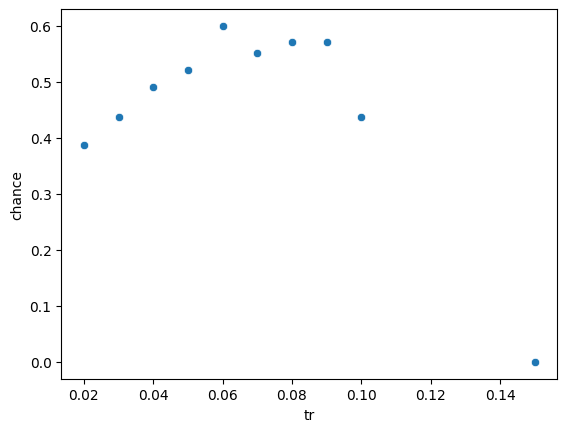

In [ ]:
sns.scatterplot(x=res_df['tr'], y=res_df['chance'])

In [ ]:
tr = 0.06
save = df.copy()
# учим на трейне первый алгоритм и предсказываем на всем датасете
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 43)
rf.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train','is_inner_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train','is_inner_train'], axis = 1))[:, 1]
df['rf1_preds'] = preds

df.loc[(df['is_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] > 1 - tr), 'y'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] <= tr) | (df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1

rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 43)
rf2.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds','is_inner_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds','is_inner_train'], axis = 1))[:, 1]
df['rf2_preds'] = preds2

df_sorted = df[df['is_train'] == 0].sort_values(by=['rf2_preds'], ascending=False).head(N).copy()
times = round(df_sorted['truth'].mean() / random_send, 3)
print(f'tr = {tr}, ', 'шансы набрать единичек в топ-N ', round(df_sorted['truth'].mean(), 3), f', они лучше случайных в {times} раз')
df = save.copy()

tr = 0.06,  шансы набрать единичек в топ-N  0.847 б они лучше случайных в 1.875 раз


Обычный RF был лучше случайного в 1.46 раз

## Итого:

Шансов набрать N единичек из неразмеченной выборки для рекламы:



*   Ищем случайно -- 45%
*   Ищем моделью -- 66% (в 1,5 раза лучше случайного)
*   c PU -- 85% (в 1.9 раза лучше случайного)







# 4. LaL и PU поближе к реальности

## Добавим шум и дисбаланс классов

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
np.random.seed(42)
n_features = 10
n_samples = 100_000
N = 2200
df, y = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, flip_y = 0.03, weights = [0.99])
df = pd.DataFrame(df, columns = [f'feature_{k}' for k in range(n_features)])
df['y'] = y
cnt = df[df['y'] == 1]['y'].count()
print(f'исходное число единичек {cnt}')

# Unlabel a certain number of data points
hidden_size =  N

def unlabel(df, hidden_size):
  # Keep the original targets safe for later
  df_orig = df.copy()

  df.loc[
      np.random.choice(
          df[df['y'] == 1].index,
          replace = False,
          size = hidden_size
      )
  , 'y'] = 0
  return df, df_orig

df, df_orig = unlabel(df, hidden_size)
print('после сокрытия единичек', df[df['y'] == 1]['y'].count())
df['truth'] = df_orig['y']

исходное число единичек 2554
после сокрытия единичек 354


In [ ]:
df[df['truth'] == 1].shape[0]

2554

In [ ]:
# если случайно взять неразмеченных, то доля истинных единичек в ней составит 2.2%
df[(df['y'] == 0) & (df['truth'] == 1)].shape[0] / df[df['y'] == 0].shape[0]

0.022078156674628185

In [ ]:
# отложим train -- все доступные единички + 30% от неразмеченной выборки
count_zeros = df[df['y'] == 0]['y'].count()
rate = 0.3
df['is_train'] = 0
train_index = pd.concat([df[df['y'] == 1].copy(), df[df['y'] == 0].sample(int(count_zeros * rate), random_state=1)]).index
df.loc[df.index.isin(train_index), 'is_train'] = 1
df[df['is_train'] == 1].shape

(30247, 13)

In [ ]:
# проверяем что скрыли только единички
print(recall_score(df['truth'], df['y']), precision_score(df['truth'], df['y']))

0.13860610806577917 1.0


In [ ]:
# учим на трейне первый алгоритм и предсказываем на всем датасете
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
rf.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train'], axis = 1))[:, 1]
df['rf1_preds'] = preds

In [ ]:
# его качество на тесте
from sklearn.metrics import roc_auc_score
roc_auc_score(df[df['is_train'] == 0]['truth'], df[df['is_train'] == 0]['rf1_preds'])

0.6332965396623095

In [ ]:
df_sorted = df[df['is_train'] == 0].sort_values(by=['rf1_preds'], ascending=False).head(N).copy()
df_sorted['truth'].mean()

0.15363636363636363

In [ ]:
random_send = df[df['is_train'] == 0]['truth'].mean()
random_send

0.02256533769156882

В 6,8 раз лучше случайного

In [ ]:
df_sorted['truth'].mean() / random_send

6.80851160910246

In [ ]:
# от трейна отделим выборку, ее будем обогащать неразмеченными ноликами,
# на тесте выбирать порог, потом с этим порогом обучимся и посмотрим как поменялись шансы
count_train = df[df['is_train'] == 1].shape[0]
rate = 0.7
df['is_inner_train'] = 0
inner_train_index = df[df['is_train'] == 1].sample(int(count_train * rate), random_state=1).index
df.loc[df.index.isin(inner_train_index), 'is_inner_train'] = 1

In [ ]:
df.loc[df['is_inner_train'] == 1].shape

(21172, 15)

In [ ]:
save = df.copy()
res = []
for tr in [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.35, 0.4]:
  rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
  rf.fit(df[df['is_inner_train'] == 1].drop(['y', 'truth', 'is_train', 'is_inner_train'], axis = 1), df[df['is_inner_train'] == 1]['y'])
  preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train', 'is_inner_train'], axis = 1))[:, 1]
  df['rf1_preds'] = preds

  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & (df['rf1_preds'] > 1- tr), 'y'] = 1
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & ((df['rf1_preds'] <= tr)), 'is_inner_train'] = 1
  df.loc[(df['is_train'] == 1) & (df['is_inner_train'] == 0) & ((df['rf1_preds'] > 1 - tr)), 'is_inner_train'] = 1

  # print(df[df['is_inner_train'] == 1].shape)
  rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
  rf2.fit(df[df['is_inner_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds', 'is_inner_train'], axis = 1), df[df['is_inner_train'] == 1]['y'])
  preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds', 'is_inner_train'], axis = 1))[:, 1]
  df['rf2_preds'] = preds2
  test = df[(df['is_train'] == 1)&(df['is_inner_train'] == 0)][['y', 'rf2_preds']].copy()

  small_N = int(df[(df['is_inner_train'] == 1) & (df['y'] == 1)].shape[0] * (N / df.loc[(df['is_train'] == 1) & (df['y'] == 1)].shape[0]))
  small_df_sorted = df[(df['is_train'] == 1) & (df['is_inner_train'] == 0)].sort_values(by=['rf2_preds'], ascending=False).head(small_N).copy()
  new_chances = small_df_sorted['y'].mean()
  print(tr, new_chances, random_send)
  res.append([tr, round(new_chances, 3)])
  df = save.copy()

0.02 0.7263157894736842 0.02256533769156882
0.03 0.7213114754098361 0.02256533769156882
0.04 0.74 0.02256533769156882
0.05 0.8055555555555556 0.02256533769156882
0.06 0.8 0.02256533769156882
0.07 0.8 0.02256533769156882
0.08 0.8 0.02256533769156882
0.09 0.8181818181818182 0.02256533769156882
0.1 0.75 0.02256533769156882
0.15 0.5 0.02256533769156882
0.2 0.5 0.02256533769156882
0.22 0.0 0.02256533769156882
0.25 0.0 0.02256533769156882
0.3 nan 0.02256533769156882
0.35 nan 0.02256533769156882
0.4 nan 0.02256533769156882


In [ ]:
pd.DataFrame(res, columns = ['tr', 'chance']).sort_values(by = 'chance', ascending = False)

,tr,chance
7,0.09,0.818
3,0.05,0.806
4,0.06,0.800
5,0.07,0.800
6,0.08,0.800
8,0.10,0.750
2,0.04,0.740
0,0.02,0.726
1,0.03,0.721
9,0.15,0.500


In [ ]:
res_df = pd.DataFrame(res, columns = ['tr', 'chance']).sort_values(by = 'chance', ascending = False)
res_df = res_df[res_df['tr'] < 0.14].copy()

<Axes: xlabel='tr', ylabel='chance'>

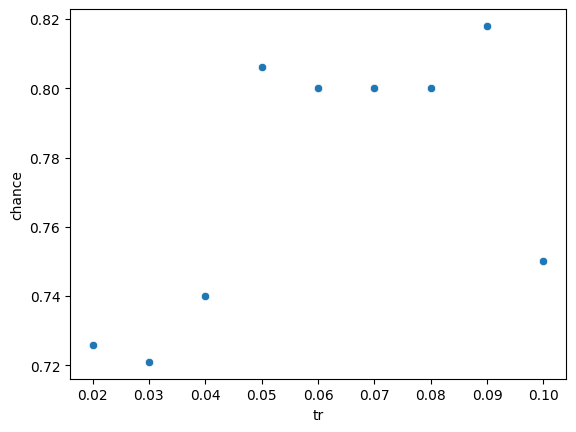

In [ ]:
sns.scatterplot(x=res_df['tr'], y=res_df['chance'])

In [ ]:
tr = 0.09
save = df.copy()
# учим на трейне первый алгоритм и предсказываем на всем датасете
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 43)
rf.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train','is_inner_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train','is_inner_train'], axis = 1))[:, 1]
df['rf1_preds'] = preds

df.loc[(df['is_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] > 1 - tr), 'y'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] <= tr) | (df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1

rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 43)
rf2.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds','is_inner_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds','is_inner_train'], axis = 1))[:, 1]
df['rf2_preds'] = preds2

df_sorted = df[df['is_train'] == 0].sort_values(by=['rf2_preds'], ascending=False).head(N).copy()
times = round(df_sorted['truth'].mean() / random_send, 3)
print(f'tr = {tr}, ', 'шансы набрать единичек в топ-N ', round(df_sorted['truth'].mean(), 3), f', они лучше случайных в {times} раз')
df = save.copy()

tr = 0.09,  шансы набрать единичек в топ-N  0.804 , они лучше случайных в 35.645 раз


А было 6,8 раз лучше случайного

## Итого:

Шансов набрать N единичек из неразмеченной выборки для рекламы:

*   Ищем случайно -- 2,3%
*   Ищем моделью -- 15,4% (в 6,8 раз лучше случайного)
*   c PL -- 80% (в 35,6 раза лучше случайного)

